In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from IPython.display import Image
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [23]:
# Mobilenet expects 224 * 224 image
def prepare_image(file):
    img_path = './Images/dataset/with_mask/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

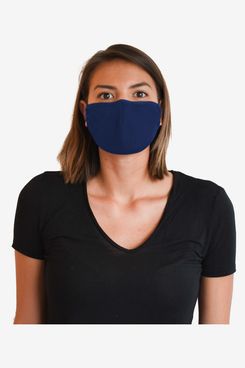

In [34]:
Image(filename='./Images/dataset/with_mask/image_0.png', width=300, height=200)

In [35]:
preprocessed_image = prepare_image('image_0.png')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n04355933', 'sunglass', 0.54441905),
  ('n03595614', 'jersey', 0.1874066),
  ('n02916936', 'bulletproof_vest', 0.103162184),
  ('n04356056', 'sunglasses', 0.09020485),
  ('n02667093', 'abaya', 0.015122795)]]